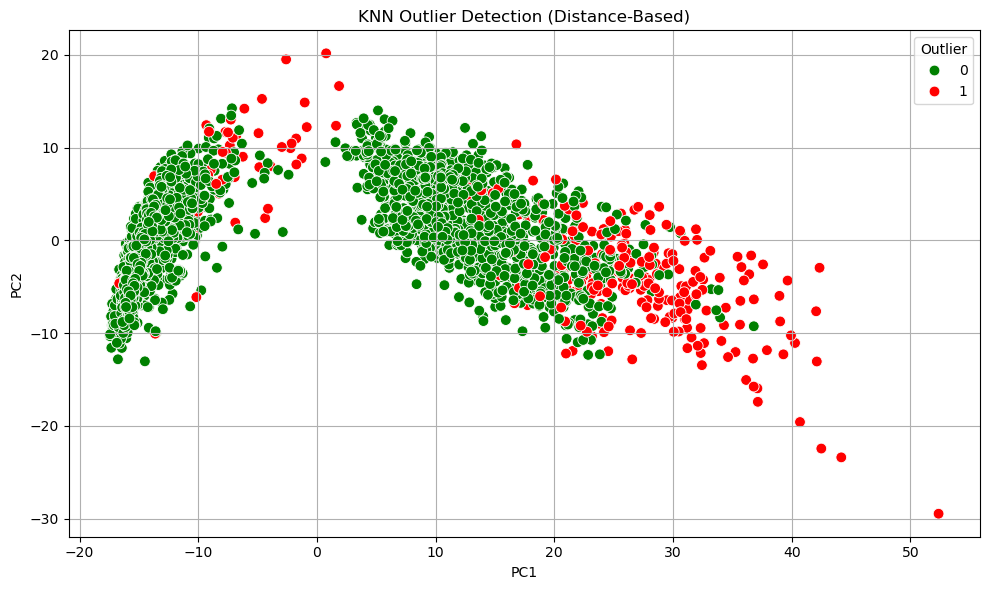

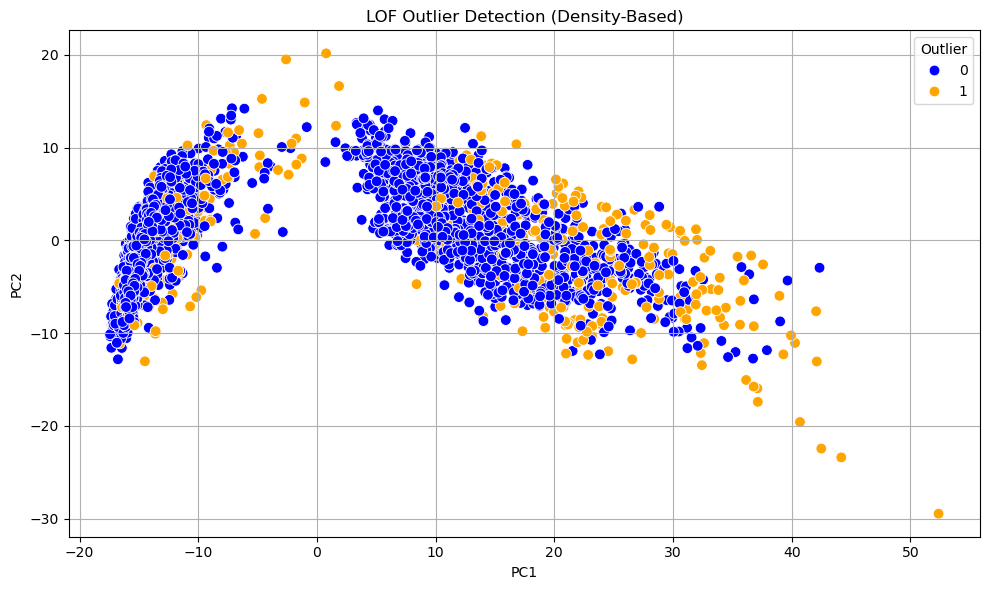

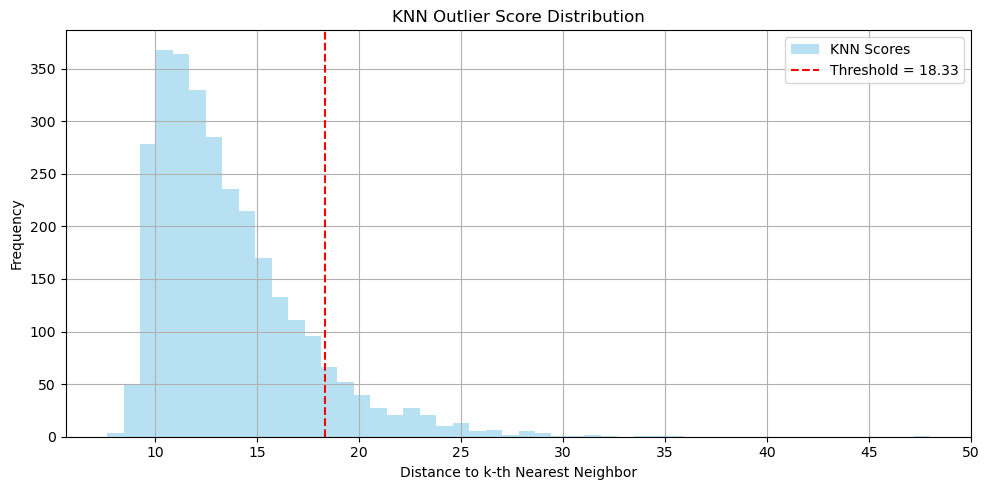

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
train_df = pd.read_csv('harus_archive/train.csv')
test_df = pd.read_csv('harus_archive/test.csv')

# Identify numeric and categorical columns
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
])

# Combine and transform
combined_df = pd.concat([train_df, test_df], axis=0)
processed_combined = preprocessor.fit_transform(combined_df)

# Split back
X_train = processed_combined[:len(train_df)]
X_test = processed_combined[len(train_df):]

# -------------------------------
# Distance-based KNN
# -------------------------------
def knn_outlier_detection(X, k=5, threshold_percentile=90):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    outlier_scores = distances[:, -1]
    threshold = np.percentile(outlier_scores, threshold_percentile)
    predictions = (outlier_scores > threshold).astype(int)
    return predictions, outlier_scores, threshold

knn_preds, knn_scores, knn_threshold = knn_outlier_detection(X_test)

# -------------------------------
# Density-based LOF
# -------------------------------
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=True)
lof.fit(X_train)
lof_preds = lof.predict(X_test)
lof_preds = np.where(lof_preds == -1, 1, 0)
lof_scores = -lof.decision_function(X_test)

# -------------------------------
# Save results
# -------------------------------
results = pd.DataFrame({
    "KNN_Score": knn_scores,
    "KNN_Outlier": knn_preds,
    "LOF_Score": lof_scores,
    "LOF_Outlier": lof_preds
})

# Add PCA for visualization
pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test)
results['PC1'] = X_test_2d[:, 0]
results['PC2'] = X_test_2d[:, 1]

# Save final CSV
results.to_csv("outlier_results.csv", index=False)

# -------------------------------
# Visualizations
# -------------------------------

# KNN Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results, x="PC1", y="PC2", hue="KNN_Outlier", palette={0: "green", 1: "red"}, s=60)
plt.title("KNN Outlier Detection (Distance-Based)")
plt.legend(title="Outlier")
plt.grid(True)
plt.tight_layout()
plt.show()

# LOF Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results, x="PC1", y="PC2", hue="LOF_Outlier", palette={0: "blue", 1: "orange"}, s=60)
plt.title("LOF Outlier Detection (Density-Based)")
plt.legend(title="Outlier")
plt.grid(True)
plt.tight_layout()
plt.show()

# KNN Score Distribution
plt.figure(figsize=(10, 5))
plt.hist(knn_scores, bins=50, alpha=0.6, color='skyblue', label="KNN Scores")
plt.axvline(knn_threshold, color='red', linestyle='--', label=f"Threshold = {knn_threshold:.2f}")
plt.title("KNN Outlier Score Distribution")
plt.xlabel("Distance to k-th Nearest Neighbor")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


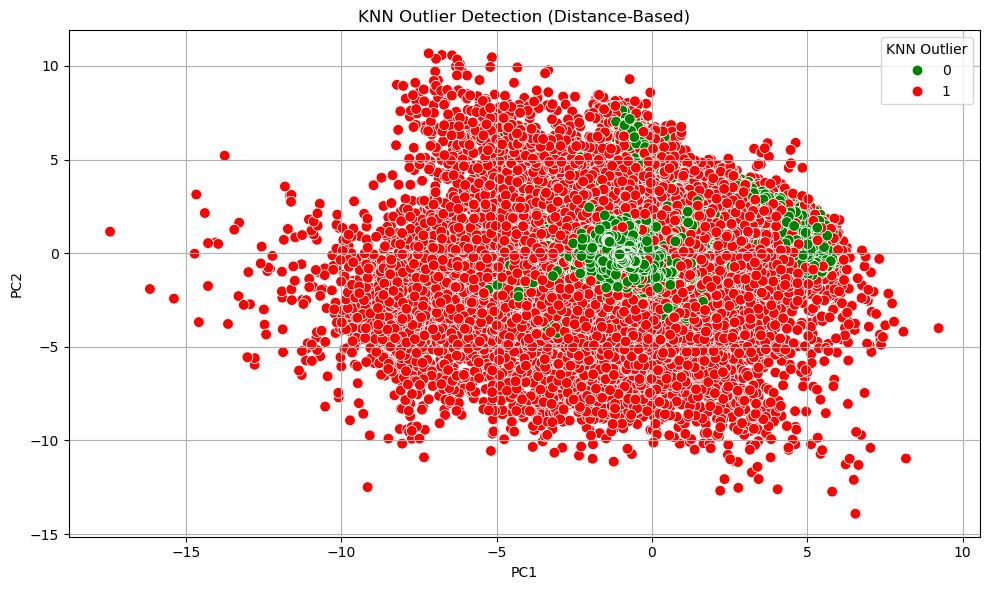

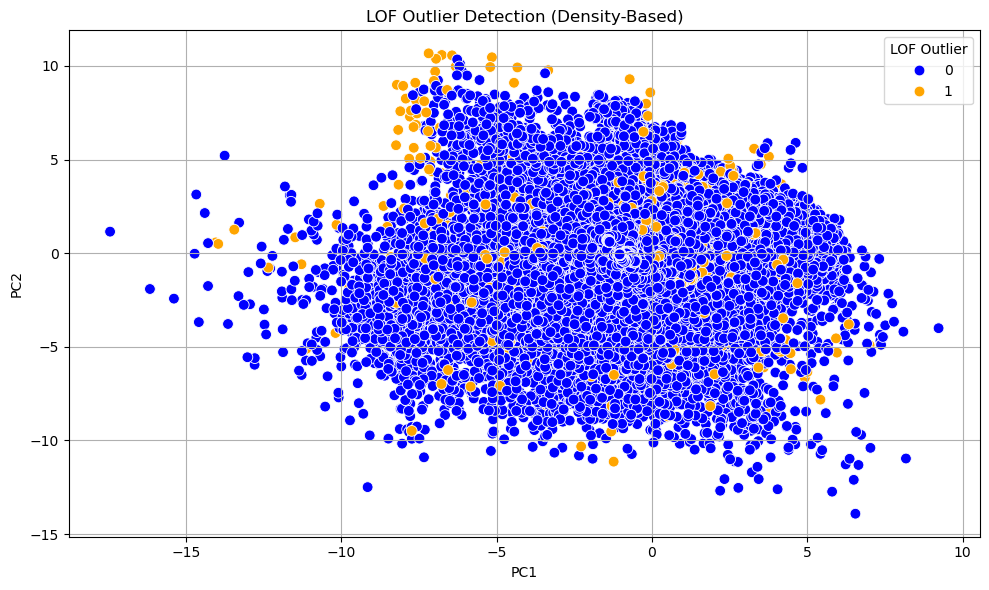

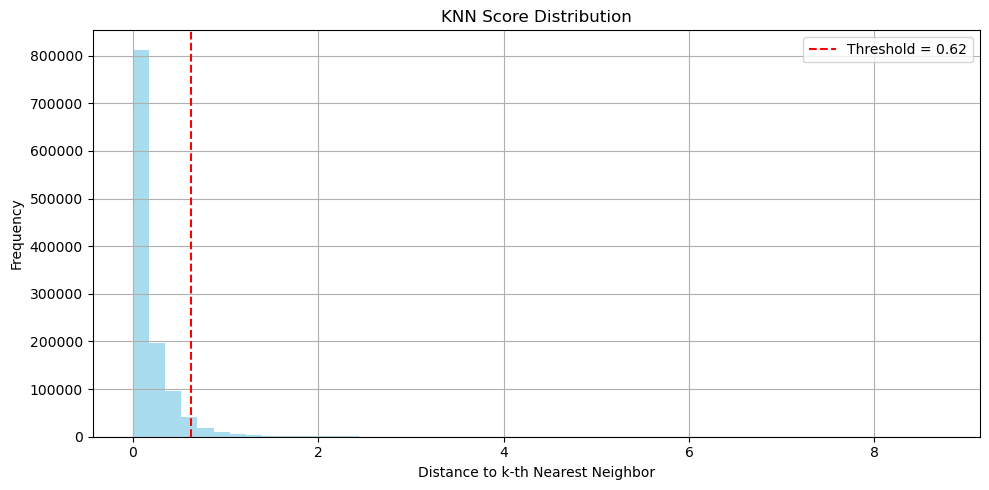

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

# Load train and test datasets
train_df = pd.read_csv('archive_harth/train.csv')
test_df = pd.read_csv('archive_harth/test.csv')

# Identify column types
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()

# Build a preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
])

# Fit on train, transform both
X_train = preprocessor.fit_transform(train_df)
X_test = preprocessor.transform(test_df)

# -------------------------------
# Distance-Based KNN Outlier Detection
# -------------------------------
def knn_outlier_detection(X, k=5, threshold_percentile=95):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    outlier_scores = distances[:, -1]
    threshold = np.percentile(outlier_scores, threshold_percentile)
    predictions = (outlier_scores > threshold).astype(int)
    return predictions, outlier_scores, threshold

knn_preds, knn_scores, knn_threshold = knn_outlier_detection(X_test)

# -------------------------------
# Density-Based LOF (Trained on train set)
# -------------------------------
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=True)
lof.fit(X_train)
lof_preds = lof.predict(X_test)
lof_preds = np.where(lof_preds == -1, 1, 0)
lof_scores = -lof.decision_function(X_test)

# -------------------------------
# PCA for 2D Visualization
# -------------------------------
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# -------------------------------
# Create Result DataFrame
# -------------------------------
results = pd.DataFrame({
    'PC1': X_test_pca[:, 0],
    'PC2': X_test_pca[:, 1],
    'KNN_Score': knn_scores,
    'KNN_Outlier': knn_preds,
    'LOF_Score': lof_scores,
    'LOF_Outlier': lof_preds
})

# Save to CSV
results.to_csv('harth_outliers.csv', index=False)

# -------------------------------
# Visualizations
# -------------------------------

# KNN Outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results, x='PC1', y='PC2', hue='KNN_Outlier', palette={0: 'green', 1: 'red'}, s=60)
plt.title('KNN Outlier Detection (Distance-Based)')
plt.legend(title='KNN Outlier')
plt.grid(True)
plt.tight_layout()
plt.show()

# LOF Outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results, x='PC1', y='PC2', hue='LOF_Outlier', palette={0: 'blue', 1: 'orange'}, s=60)
plt.title('LOF Outlier Detection (Density-Based)')
plt.legend(title='LOF Outlier')
plt.grid(True)
plt.tight_layout()
plt.show()

# KNN Score Histogram
plt.figure(figsize=(10, 5))
plt.hist(knn_scores, bins=50, alpha=0.7, color='skyblue')
plt.axvline(knn_threshold, color='red', linestyle='--', label=f'Threshold = {knn_threshold:.2f}')
plt.title('KNN Score Distribution')
plt.xlabel('Distance to k-th Nearest Neighbor')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


✅ Loaded 846 valid rows
      timestamp         x         y         z
0  703825970000 -0.430956  9.892841 -0.421380
1  704023879000 -0.536301  9.873688 -0.210690
2  704224437000 -0.593762  9.911995  0.057461
3  704239121000 -0.593762  9.902418 -0.114922
4  704249841000 -0.641646  9.864111 -0.201113
✅ Results saved to BSC_acc_7_3_outliers_cleaned.csv


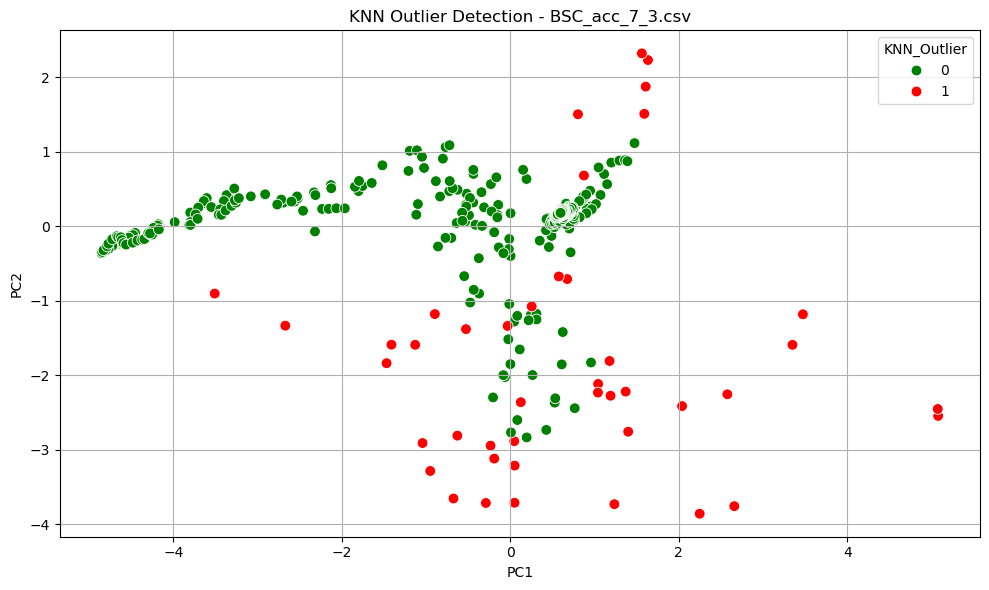

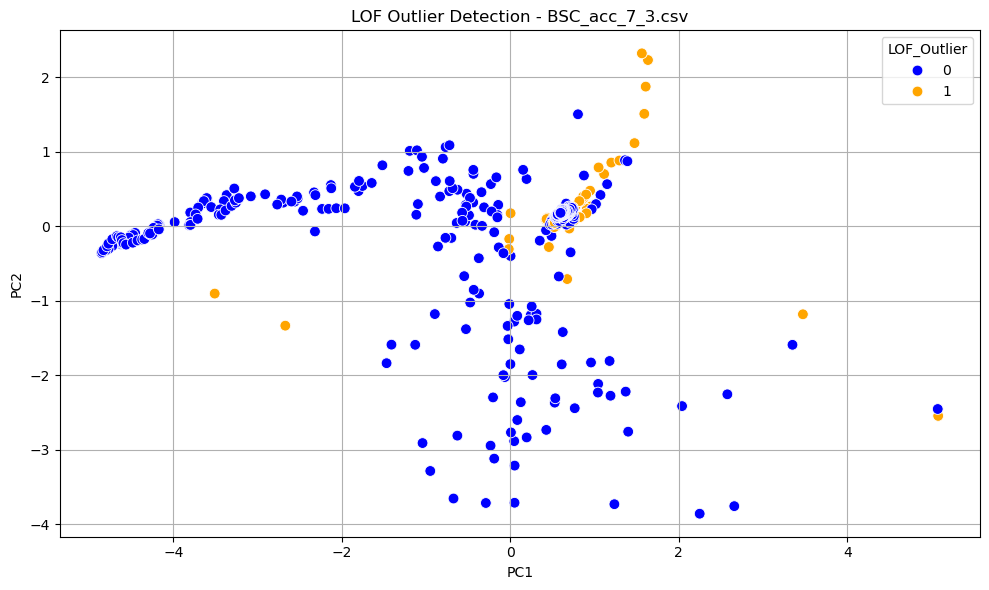

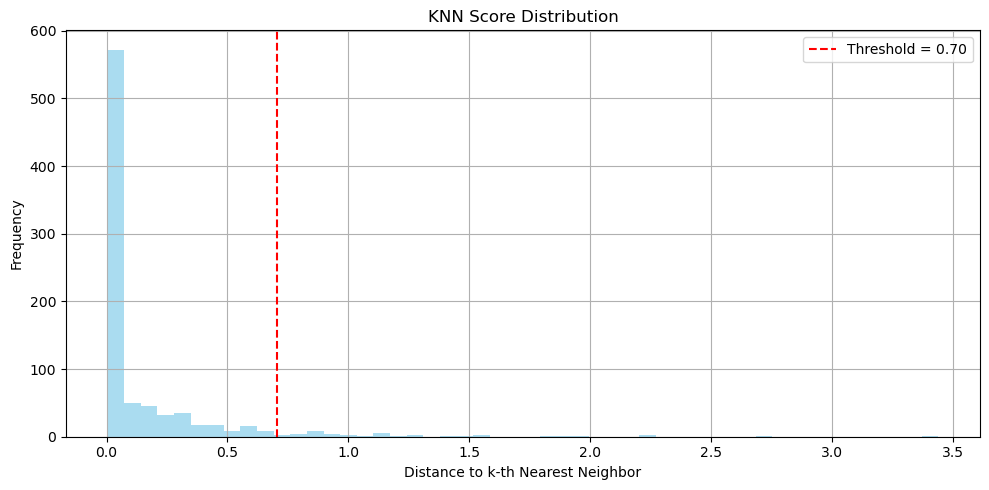

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Step 1: Load & Clean the File
# -----------------------------
clean_rows = []

with open("MobiFall_CSV/BSC_acc_7_3.csv", "r") as file:
    for line in file:
        line = line.strip()
        if line.startswith("#") or line == "":
            continue
        # Remove quotes, strip whitespace and trailing commas
        parts = [p.replace('"', '').strip().rstrip(',') for p in line.split(',')]
        if len(parts) == 4:
            try:
                timestamp = int(parts[0])
                x = float(parts[1])
                y = float(parts[2])
                z = float(parts[3])
                clean_rows.append([timestamp, x, y, z])
            except ValueError:
                continue  # skip malformed lines

# Validate
if not clean_rows:
    raise ValueError("❌ No valid numeric rows found in the file.")

df = pd.DataFrame(clean_rows, columns=["timestamp", "x", "y", "z"])
print(f"✅ Loaded {len(df)} valid rows")
print(df.head())

# -----------------------------
# Step 2: Preprocess the Data
# -----------------------------
features = df[["x", "y", "z"]]
scaler = StandardScaler()
X = scaler.fit_transform(features)

# -----------------------------
# Step 3: KNN Outlier Detection
# -----------------------------
def knn_outlier_detection(X, k=5, threshold_percentile=95):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    outlier_scores = distances[:, -1]
    threshold = np.percentile(outlier_scores, threshold_percentile)
    predictions = (outlier_scores > threshold).astype(int)
    return predictions, outlier_scores, threshold

knn_preds, knn_scores, knn_threshold = knn_outlier_detection(X)

# -----------------------------
# Step 4: LOF Outlier Detection
# -----------------------------
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_preds = lof.fit_predict(X)
lof_preds = np.where(lof_preds == -1, 1, 0)
lof_scores = -lof.negative_outlier_factor_

# -----------------------------
# Step 5: PCA for Visualization
# -----------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# -----------------------------
# Step 6: Save Results
# -----------------------------
results = pd.DataFrame({
    "timestamp": df["timestamp"],
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "KNN_Score": knn_scores,
    "KNN_Outlier": knn_preds,
    "LOF_Score": lof_scores,
    "LOF_Outlier": lof_preds
})

results.to_csv("BSC_acc_7_3_outliers_cleaned.csv", index=False)
print("✅ Results saved to BSC_acc_7_3_outliers_cleaned.csv")

# -----------------------------
# Step 7: Visualizations
# -----------------------------
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results, x="PC1", y="PC2", hue="KNN_Outlier", palette={0: "green", 1: "red"}, s=60)
plt.title("KNN Outlier Detection - BSC_acc_7_3.csv")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=results, x="PC1", y="PC2", hue="LOF_Outlier", palette={0: "blue", 1: "orange"}, s=60)
plt.title("LOF Outlier Detection - BSC_acc_7_3.csv")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(knn_scores, bins=50, alpha=0.7, color="skyblue")
plt.axvline(knn_threshold, color="red", linestyle="--", label=f"Threshold = {knn_threshold:.2f}")
plt.title("KNN Score Distribution")
plt.xlabel("Distance to k-th Nearest Neighbor")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🔍 Generating and analyzing dataset: HARTH
🔍 Generating and analyzing dataset: HARUS
🔍 Generating and analyzing dataset: MobiAct


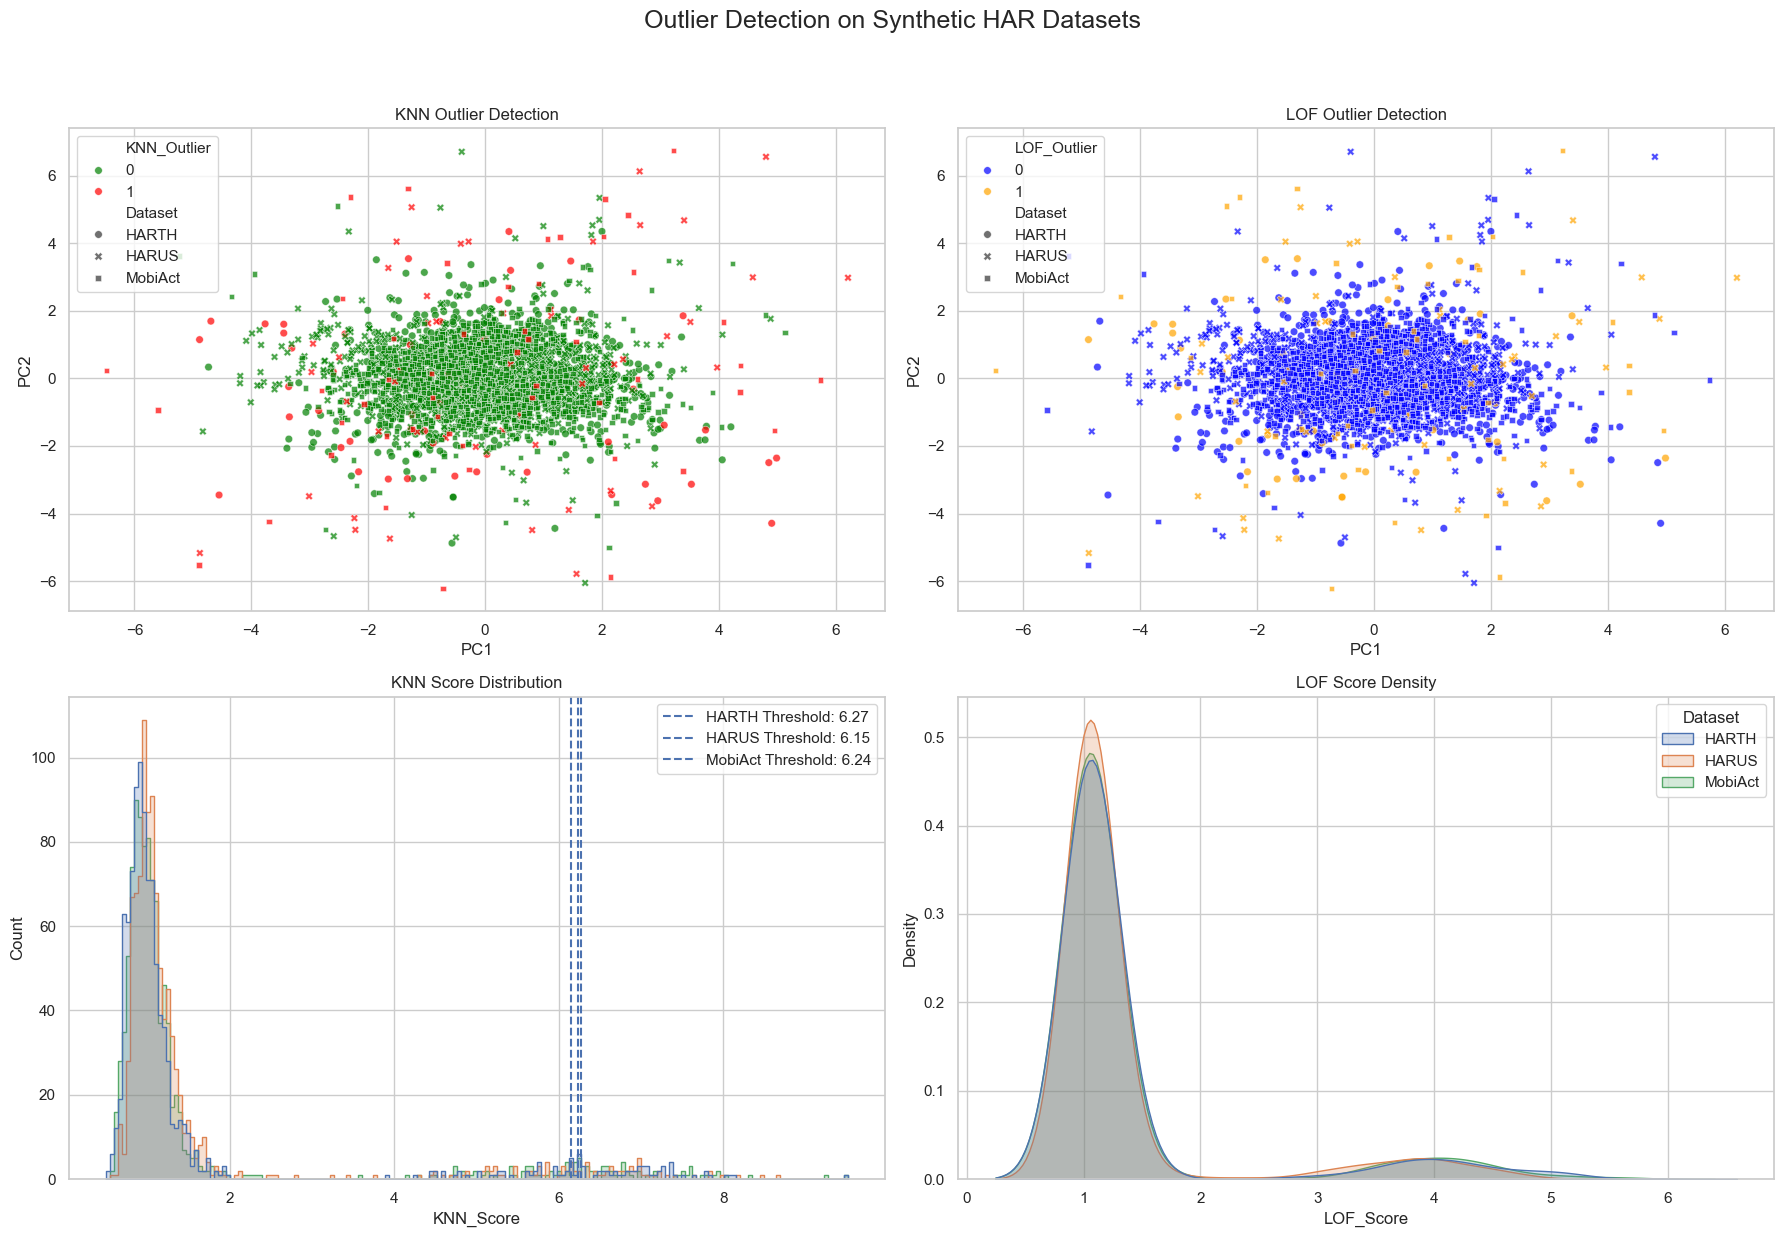

In [7]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
import matplotlib.pyplot as plt
import seaborn as sns
import os

# -------------------------------
# Parameters
# -------------------------------
USE_TSNE = False
SAVE_PLOTS = True
OUTPUT_DIR = "outlier_analysis_output"
KNN_K = 5
KNN_PERCENTILE = 95
LOF_NEIGHBORS = 20
LOF_CONTAMINATION = 0.05
SAMPLES_PER_DATASET = 1000
OUTLIERS_PER_DATASET = 100
np.random.seed(42)

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# -------------------------------
# Utilities
# -------------------------------
def generate_dataset(name, n_samples=SAMPLES_PER_DATASET, n_features=10, n_outliers=OUTLIERS_PER_DATASET):
    X, _ = make_classification(n_samples=n_samples - n_outliers,
                               n_features=n_features,
                               n_informative=6,
                               n_redundant=2,
                               n_clusters_per_class=1,
                               flip_y=0.01)
    
    outliers = np.random.uniform(low=-10, high=10, size=(n_outliers, n_features))
    X = np.vstack([X, outliers])
    
    y_true = np.array([0] * (n_samples - n_outliers) + [1] * n_outliers)
    
    shift = {
        "HARTH": 0,
        "HARUS": 5,
        "MobiAct": -5
    }.get(name, 0)
    
    X += shift
    return pd.DataFrame(X), y_true

def knn_outlier_detection(X, k=5, threshold_percentile=95):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    scores = distances[:, -1]
    threshold = np.percentile(scores, threshold_percentile)
    preds = (scores > threshold).astype(int)
    return preds, scores, threshold

def dimensionality_reduction(X, method="pca"):
    if method == "pca":
        reducer = PCA(n_components=2)
    elif method == "tsne":
        reducer = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
    return reducer.fit_transform(X)

def analyze_synthetic(name):
    print(f"🔍 Generating and analyzing dataset: {name}")
    df, true_labels = generate_dataset(name)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    
    knn_preds, knn_scores, knn_thresh = knn_outlier_detection(X_scaled, k=KNN_K, threshold_percentile=KNN_PERCENTILE)

    lof = LocalOutlierFactor(n_neighbors=LOF_NEIGHBORS, contamination=LOF_CONTAMINATION)
    lof_preds = np.where(lof.fit_predict(X_scaled) == -1, 1, 0)
    lof_scores = -lof.negative_outlier_factor_

    embed = dimensionality_reduction(X_scaled, method="tsne" if USE_TSNE else "pca")

    result_df = pd.DataFrame({
        "PC1": embed[:, 0],
        "PC2": embed[:, 1],
        "KNN_Score": knn_scores,
        "KNN_Outlier": knn_preds,
        "LOF_Score": lof_scores,
        "LOF_Outlier": lof_preds,
        "TrueLabel": true_labels,
        "Dataset": name
    })

    return result_df, knn_thresh

# -------------------------------
# Run All Synthetic Datasets
# -------------------------------
datasets = ["HARTH", "HARUS", "MobiAct"]
all_results = []
thresholds = {}

for dataset in datasets:
    df, thresh = analyze_synthetic(dataset)
    all_results.append(df)
    thresholds[dataset] = thresh

final_df = pd.concat(all_results, ignore_index=True)
final_df.to_csv(f"{OUTPUT_DIR}/synthetic_combined_outliers.csv", index=False)

# -------------------------------
# Visualization
# -------------------------------
sns.set(style="whitegrid")

fig, axs = plt.subplots(2, 2, figsize=(18, 13))
fig.suptitle("Outlier Detection on Synthetic HAR Datasets", fontsize=18)

# KNN Outlier View
sns.scatterplot(ax=axs[0, 0], data=final_df, x="PC1", y="PC2", hue="KNN_Outlier", style="Dataset",
                palette={0: "green", 1: "red"}, s=30, alpha=0.7)
axs[0, 0].set_title("KNN Outlier Detection")

# LOF Outlier View
sns.scatterplot(ax=axs[0, 1], data=final_df, x="PC1", y="PC2", hue="LOF_Outlier", style="Dataset",
                palette={0: "blue", 1: "orange"}, s=30, alpha=0.7)
axs[0, 1].set_title("LOF Outlier Detection")

# KNN Score Distribution
sns.histplot(ax=axs[1, 0], data=final_df, x="KNN_Score", hue="Dataset", element="step", common_norm=False)
for name, thresh in thresholds.items():
    axs[1, 0].axvline(thresh, linestyle='--', label=f"{name} Threshold: {thresh:.2f}")
axs[1, 0].legend()
axs[1, 0].set_title("KNN Score Distribution")

# LOF Score Distribution
sns.kdeplot(ax=axs[1, 1], data=final_df, x="LOF_Score", hue="Dataset", fill=True)
axs[1, 1].set_title("LOF Score Density")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

if SAVE_PLOTS:
    plt.savefig(f"{OUTPUT_DIR}/synthetic_outlier_visualization.png", dpi=300)
plt.show()
